In [6]:
#hide
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()
     

#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
     


In [ ]:
cred_path = Path('').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path
     

In [9]:
#hide
Path.BASE_PATH = path
     

In [10]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#7) [Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('median_benchmark.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('TrainAndValid.csv')]

In [11]:

df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [12]:


df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [13]:


df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [14]:


sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [15]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered=True)

In [16]:
dep_var = 'SalePrice'

In [17]:
df[dep_var] = np.log(df[dep_var])

In [ ]:
df = add_datepart(df, 'saledate')

In [ ]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [20]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [21]:
procs = [Categorify, FillMissing]

In [22]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [23]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
     

In [24]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [25]:
len(to.train),len(to.valid)

(404710, 7988)

In [26]:


#hide_output
to.show(3)
     

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [27]:


#hide_input
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)
     

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [28]:


#hide_output
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [29]:


#hide_input
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [30]:


to.classes['ProductSize']


['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [31]:


save_pickle(path/'to.pkl',to)

In [32]:
path.ls(file_type='pkl')

(#18) [Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('bluebook-for-bulldozers.zip'),Path('median_benchmark.csv'),Path('Valid.zip'),Path('TrainAndValid.7z'),Path('Test.csv'),Path('Train.7z'),Path('xs_final.pkl'),Path('valid_xs_final.pkl')...]

In [33]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [34]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

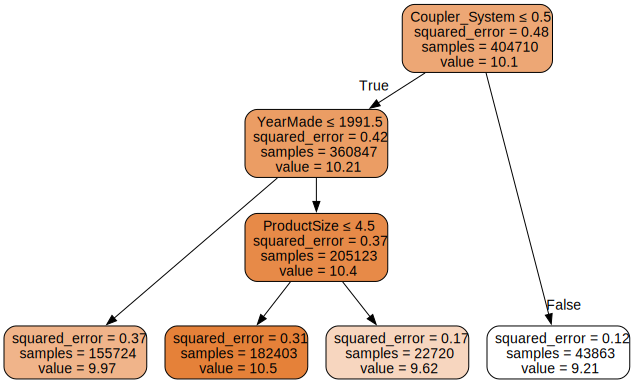

In [35]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [36]:
from dtreeviz.trees import *

In [37]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [38]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

In [39]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [40]:
m.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [41]:
def r_mse(pred, y):
       return round(math.sqrt(((pred-y)**2).mean()),6)

In [42]:
def m_rmse(m, xs, y):
       return r_mse(m.predict(xs), y)

In [43]:
m_rmse(m,xs,y)

0.0

In [44]:
m_rmse(m ,valid_xs, valid_y)

0.333798

In [45]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)

DecisionTreeRegressor(min_samples_leaf=25)

In [46]:
m_rmse(m,xs,y),m_rmse(m ,valid_xs, valid_y)

(0.248564, 0.323386)

In [47]:
m.get_n_leaves()

12397

In [48]:
def rf(xs, y, n_estimators = 40, max_samples=200_000,
       max_features= 0.5, min_samples_leaf=5, **kwargs):
       return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,
                                    min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs,y)

In [49]:
m = rf(xs,y)

In [50]:
m_rmse(m,xs,y),m_rmse(m ,valid_xs, valid_y)

(0.171014, 0.232929)

m.estimators_ = list of all the individual trees in the RandomForest.

For each tree t, t.predict(valid_xs) gives predictions on the validation set.

np.stack([...]) stacks them into a matrix.

👉 So preds has shape:

(n_trees, n_samples)


rows = trees

columns = samples (predictions for each data point)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [52]:
preds.mean()

10.171030008619113

In [53]:
r_mse(preds.mean(), valid_y)

0.725061

What .mean(0) and .mean(1) do

preds.mean(0) → average over axis 0 (trees)

Collapses the tree dimension.

Result: shape (n_samples,)

Meaning: the RandomForest average prediction per sample across all trees.

This is exactly how RandomForest prediction is defined.

preds.mean(1) → average over axis 1 (samples)

Collapses the sample dimension.

Result: shape (n_trees,)

Meaning: the average prediction each tree makes across all validation samples.

Not usually useful for model evaluation — more of a diagnostic (e.g., see if some trees are biased high/low).

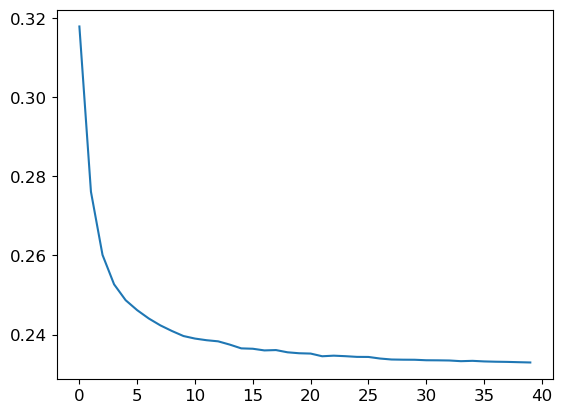

In [54]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

In [55]:
r_mse(m.oob_prediction_, y)

0.210879

In [56]:
preds.shape

(40, 7988)

In [57]:
valid_xs.shape

(7988, 66)

In [58]:
preds_std= preds.std(0)

In [59]:
preds_std[:5]

array([0.20428645, 0.12489102, 0.10870929, 0.2918193 , 0.11739124])

In [60]:
def rf_feat_importance(m, df):
       return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [61]:
fi = rf_feat_importance(m, xs)

In [62]:
fi[:10]

,cols,imp
57,YearMade,0.175234
6,ProductSize,0.111885
30,Coupler_System,0.101602
7,fiProductClassDesc,0.069464
54,ModelID,0.056922
65,saleElapsed,0.050745
32,Hydraulics_Flow,0.048636
3,fiSecondaryDesc,0.044927
31,Grouser_Tracks,0.044166
1,fiModelDesc,0.031490


In [63]:
def plot_fi(fi):
       return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<Axes: ylabel='cols'>

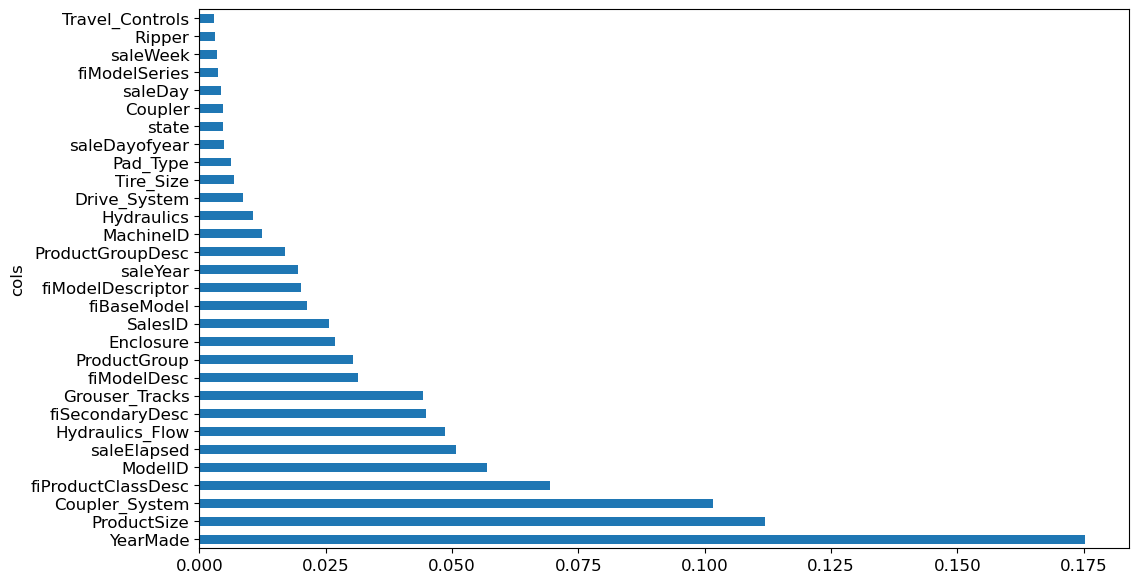

In [64]:
plot_fi(fi[:30])

In [65]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

22

In [66]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m= rf(xs_imp, y)

In [67]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.18062, 0.232125)

In [68]:
len(xs.columns), len(xs_imp.columns)

(66, 22)

<Axes: ylabel='cols'>

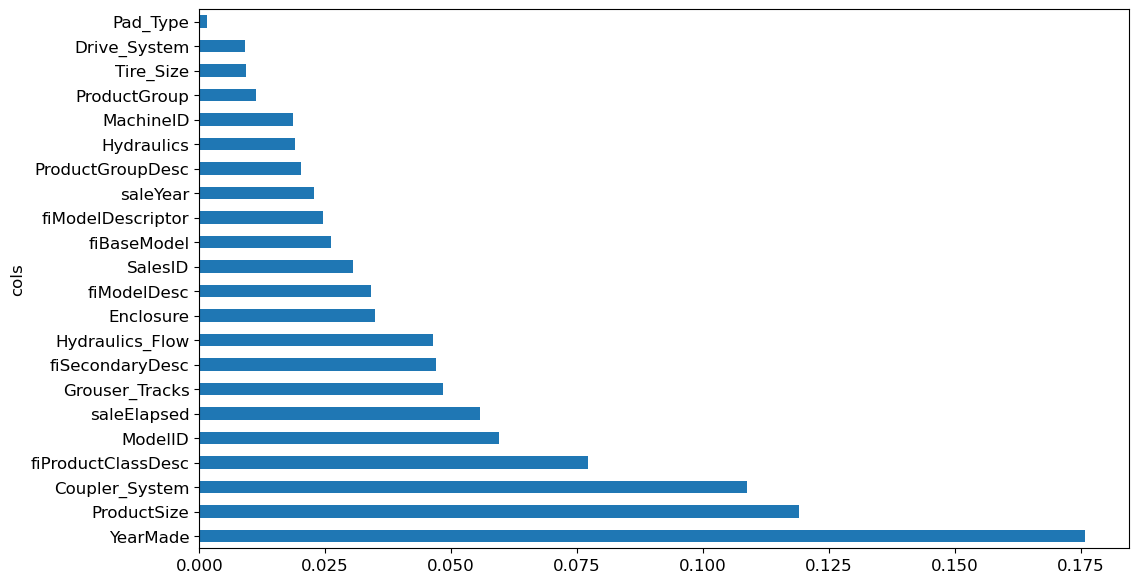

In [69]:
plot_fi(rf_feat_importance(m, xs_imp))

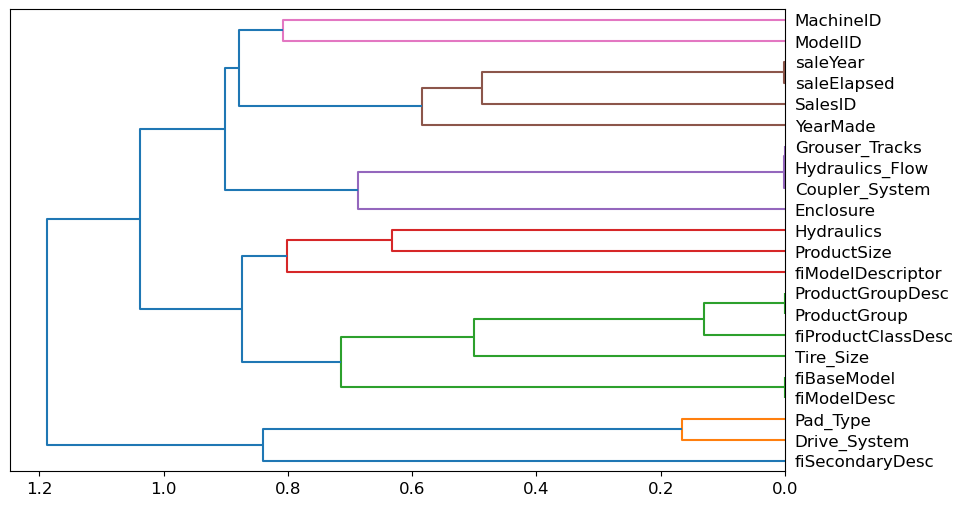

In [70]:
cluster_columns(xs_imp)

In [71]:
def get_oob(df):
       m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                                 max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
       m.fit(df,y)
       return m.oob_score_

In [72]:
get_oob(xs_imp)

0.8777268279817708

In [73]:
{c:get_oob(xs_imp.drop(c, axis= 1)) for c in ('saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8759287107105066,
 'saleElapsed': 0.8726227669781487,
 'ProductGroupDesc': 0.8772895563387307,
 'ProductGroup': 0.877528630384875,
 'fiModelDesc': 0.8751485593731694,
 'fiBaseModel': 0.8759140330566311,
 'Hydraulics_Flow': 0.8770389521975125,
 'Grouser_Tracks': 0.87751756696419,
 'Coupler_System': 0.8768672412729484}

In [74]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8755426607711057

In [75]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [76]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [77]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

(([<matplotlib.axis.YTick at 0x322c55970>,
  [Text(0, 0, '#na#'),
   Text(0, 1, 'Large'),
   Text(0, 2, 'Large / Medium'),
   Text(0, 3, 'Medium'),
   Text(0, 4, 'Small'),
   Text(0, 5, 'Mini'),
   Text(0, 6, 'Compact')]),)

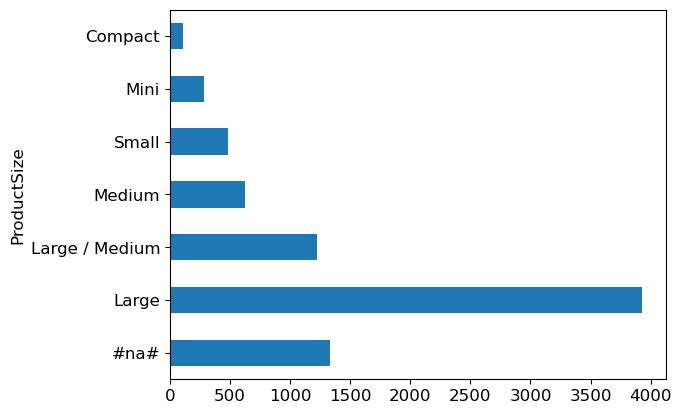

In [78]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c),

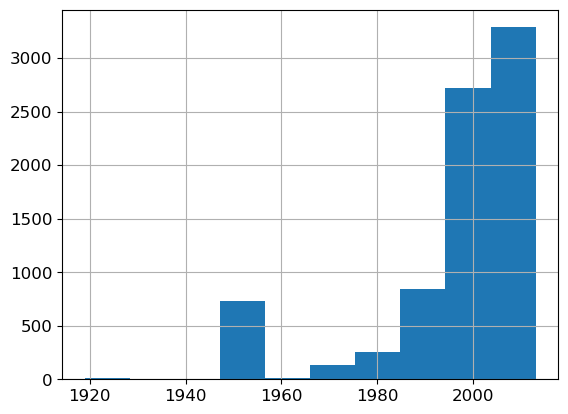

In [79]:
ax = valid_xs_final['YearMade'].hist()

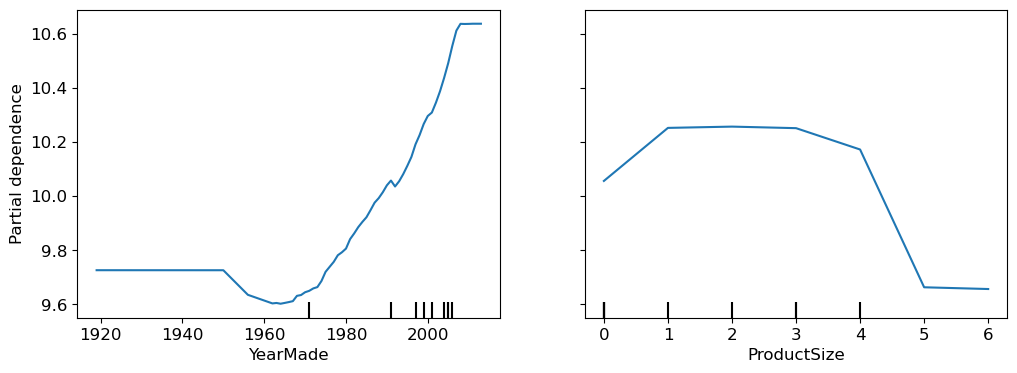

In [80]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,4))
PartialDependenceDisplay.from_estimator(
    m,                  # your trained model
    valid_xs_final,     # your dataset (features as DataFrame or array)
    ['YearMade', 'ProductSize'],  # features to plot
    ax=ax
)
plt.show()


We can do exactly the same thing, but for just a single row of data. For instance, let's say we are looking at some particular item at auction. Our model might predict that this item will be very expensive, and we want to know why. So, we take that one row of data and put it through the first decision tree, looking to see what split is used at each point throughout the tree. For each split, we see what the increase or decrease in the addition is, compared to the parent node of the tree. We do this for every tree, and add up the total change in importance by split variable.



In [81]:
from sklearn.ensemble import RandomForestClassifier as ForestClassifier
from sklearn.ensemble import RandomForestRegressor as ForestRegressor


In [83]:
m.estimator_

DecisionTreeRegressor()

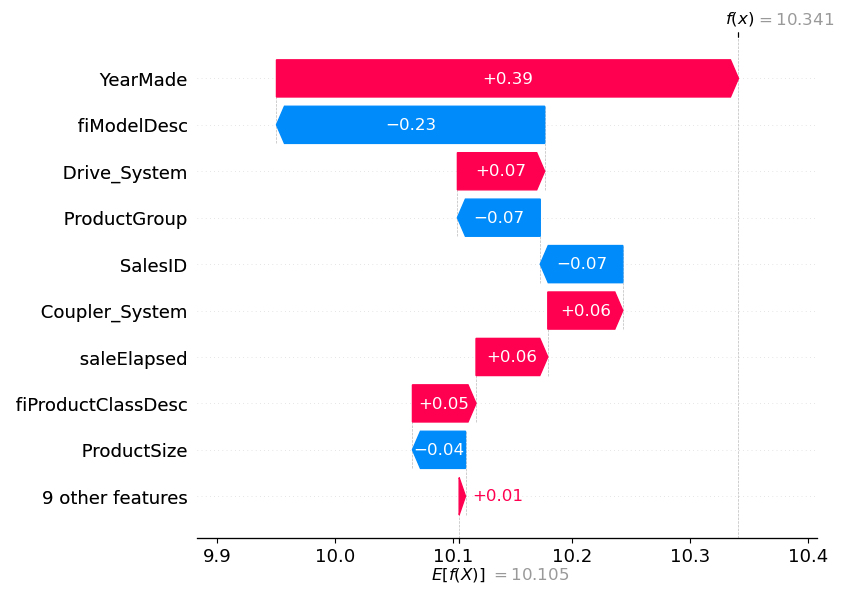

In [85]:
import shap

# explain with TreeExplainer (works with RF, XGB, LightGBM, CatBoost)
explainer = shap.TreeExplainer(m)

# pick one row
row = xs_final.iloc[0:10]

# compute shap values
shap_values = explainer.shap_values(row)

# plot waterfall
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[0],   # take the scalar
    shap_values[0],                # SHAP values for this row
    row.iloc[0]                    # feature values
)





Why bother training a “train vs valid” classifier?

The whole point is:
➡️ To check whether your validation set is a fair test of your model.

🔹 Case 1: Training and validation are from the same distribution

Suppose both sets come from the same years, same types of machines, same auction conditions.

Then a Random Forest trying to guess “train vs valid” will fail (accuracy ≈ 50%).

That’s good ✅ because it means your validation accuracy is a trustworthy estimate of future performance.

🔹 Case 2: Validation is out-of-domain

Example: training bulldozers are mostly from the 1990s, validation bulldozers are mostly from 2015–2020.

Then the “train vs valid” classifier will do really well (maybe >90% accuracy).

And the top feature importance will probably be YearMade.

This tells you: your validation set is newer than your training set → your model may fail in real deployment if data keeps shifting forward in time.

🔹 Case 3: Hidden data leakage or sampling bias

Sometimes, the validation set is accidentally collected differently (different auction sites, different IDs, etc.).

The classifier will detect those differences and highlight the columns.

That’s a big red flag 🚩 — your validation results are misleading.

⚡ So the point is:

Detect dataset shift (train vs valid mismatch).

Identify which features cause the shift.

Judge whether validation scores can be trusted.

Debug data collection mistakes (e.g. wrong sampling).

In [86]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final)+ [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.894569
11,SalesID,0.080810
13,MachineID,0.021269
0,YearMade,0.000946
10,Enclosure,0.000592
8,fiModelDesc,0.000265


In [87]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

orig 0.231993


For each suspicious feature (SalesID, saleElapsed, MachineID):

Train the model again without that column.

Measure performance again.

Compare new RMSE to original RMSE.

In [88]:
for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))


SalesID 0.230534
saleElapsed 0.23634
MachineID 0.230572


In [89]:
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229915

<Axes: >

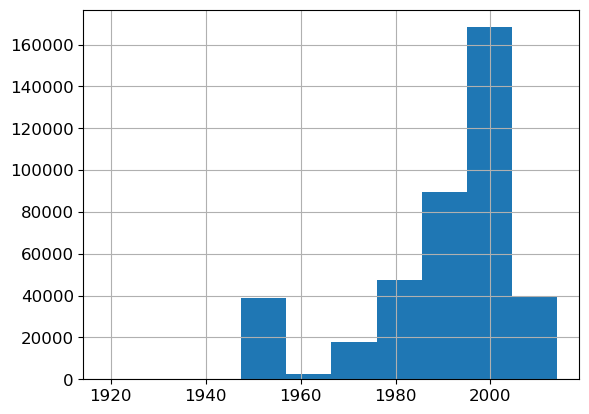

In [90]:
xs['YearMade'].hist()

In [93]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.1762, 0.22868)

In [96]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [97]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

That’s why they recommend something like max_card = 9000 → treat any column with fewer than 9,000 unique values as categorical.

In [101]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [107]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
Hydraulics_Flow          3
fiSecondaryDesc        177
fiModelDesc           5059
ProductGroup             6
Enclosure                6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
Pad_Type                 4
dtype: int64

In [108]:
xs_filt2 = xs_filt.drop('fiModelDesc', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDesc', axis=1)
m2=rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.182058, 0.232529)

In [109]:
cat_nn.remove('fiModelDesc')

In [110]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

In [111]:
dls = to_nn.dataloaders(1024)

In [112]:
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

In [113]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0002290867705596611)

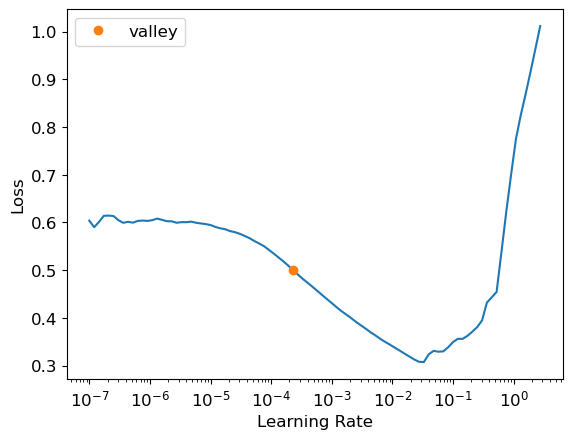

In [114]:
learn.lr_find()

In [115]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.063767,0.094942,00:08
1,0.054106,0.071837,00:07
2,0.048122,0.057354,00:07
3,0.043166,0.053317,00:07
4,0.041381,0.052312,00:08


In [116]:
preds, targs = learn.get_preds()

In [117]:
r_mse(preds, targs)

0.228717

In [119]:
learn.save('nn')

Path('models/nn.pth')